# Traffic Light Data Processing
---

#### Resources:  
1. [Tensorflow Tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)
2. [Bosch Traffic Light Dataset](https://hci.iwr.uni-heidelberg.de/node/6132)

3. [TF Records tutorial guide](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/)
4. [Converting Existing Dataset to TF record](https://medium.com/@WuStangDan/step-by-step-tensorflow-object-detection-api-tutorial-part-2-converting-dataset-to-tfrecord-47f24be9248d)
5. [TF using your own dataset.md]( https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)
6. [TF Records](http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html) - Example code to save TF records file
7. [Reading YAML file for Bosch Dataset](https://github.com/bosch-ros-pkg/bstld/blob/master/read_label_file.py)

## Environment Preparation

In [3]:
### Imports ###
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from bs4 import BeautifulSoup
import yaml
import io

### Env setup ###
# This is needed to display the images.
%matplotlib inline

# Place TF Models repository on the same directory (https://github.com/tensorflow/models)
sys.path.append("../../models/research")
sys.path.append("../../models/research/object_detection")

# Dataset folder
sys.path.append("../../dataset")

# Dataset paths
PATH_TO_GREEN_IMGS = "../../dataset/images_for_training/green/"
PATH_TO_RED_IMGS = "../../dataset/images_for_training/red/"
PATH_TO_YELLOW_IMGS = "../../dataset/images_for_training/yellow/"
PATH_TO_XML = "../../dataset/images_for_training/"
OUTPUT_PATH = os.path.dirname("../../output_data/")

# create output folder if not found
try:
    os.stat(OUTPUT_PATH)
except:
    os.mkdir(OUTPUT_PATH)

# import utils
from utils import label_map_util
from utils import visualization_utils as vis_util

## Helper Functions

In [28]:
### helper functions ###
COLOR = ["green", "red", "yellow"]
LABEL_DICT = {"Green": 1, "Red": 2, "Yellow": 3, "off": 4}
LABEL_PATH_DICT = {"Green": PATH_TO_GREEN_IMGS, "Red": PATH_TO_RED_IMGS, "Yellow": PATH_TO_YELLOW_IMGS}

# read xml file
def read_xml(XML_PATH):
    xml = ""
    with open(XML_PATH) as f:
        xml = f.readlines()
    
    return BeautifulSoup(''.join([line.strip('\t') for line in xml]), "lxml")

# get file name
def get_file_name(xml_info):
    return xml_info.find('filename').text

# get boxes from xml
def get_detected_objects(xml_info):
    return xml_info.find_all('object')

# get image size
def get_img_size(xml_info):
    return (int(xml_info.size.width.text), int(xml_info.size.height.text))

# get detected object's color
def get_object_color(obj):
    return obj.find('name').text

# get bounds from boxes
def get_boxbounds(obj):
    xmin = int(obj.bndbox.xmin.text)
    ymin = int(obj.bndbox.ymin.text)
    xmax = int(obj.bndbox.xmax.text)
    ymax = int(obj.bndbox.ymax.text)
    return (xmin, ymin, xmax, ymax)

# plot annotations
def plot_annotation_xml(IMG_PATH, XML_PATH):
    # read image and xml
    img = Image.open(IMG_PATH)
    xml_info = read_xml(XML_PATH)
    detected_objects = get_detected_objects(xml_info)
    
    # draw boxes
    for k in range(len(detected_objects)):
        # get detection info
        c = get_object_color(detected_objects[k])
        bounds = get_boxbounds(detected_objects[k])
        
        # draw box on image
        vis_util.draw_bounding_box_on_image(
        img, bounds[1], bounds[0], bounds[3], bounds[2],
        color=COLOR[LABEL_DICT[c]-1], display_str_list=(str(k+1)),
        use_normalized_coordinates = False)
    
    # plot image
    plt.imshow(img)
    plt.show()
    
# plot annotations
def plot_annotation_bosch(YAML_IMG):
    
    img = Image.open(YAML_IMG['path'])
    detected_objects = YAML_IMG['boxes']
    
    # draw boxes
    for i in range(len(detected_objects)):
        # get detection info
        c = detected_objects[i]['label']
        
        # get annotation bounds
        xmin = int(detected_objects[i]['x_min']) 
        xmax = int(detected_objects[i]['x_max'])
        ymin = int(detected_objects[i]['y_min'])
        ymax = int(detected_objects[i]['y_max'])
        
        # draw box on image
        vis_util.draw_bounding_box_on_image(
        img, ymin, xmin, ymax, xmax,
        color=COLOR[LABEL_DICT[c]-1], display_str_list=(str(i+1)),
        thickness = 6,
        use_normalized_coordinates = False)
    
    # plot image
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

## Data Exploration

In [29]:
### Loading label map ###
NUM_CLASSES = 4
PATH_TO_LABELS = '../../dataset/label_map.pbtxt'

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [30]:
### Loading images ###
# get images list
green_images_list = os.listdir(PATH_TO_GREEN_IMGS)
yellow_images_list = os.listdir(PATH_TO_YELLOW_IMGS)
red_images_list = os.listdir(PATH_TO_RED_IMGS)

num_green_imgs = len(green_images_list)
num_yellow_imgs = len(yellow_images_list)
num_red_imgs = len(red_images_list)

# Images Summary
print("Train images count: Green - {}, Yellow - {}, Red - {}".format(num_green_imgs, num_yellow_imgs, num_red_imgs) )

Train images count: Green - 196, Yellow - 147, Red - 174


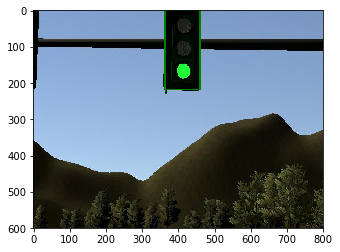

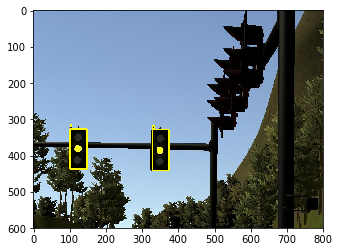

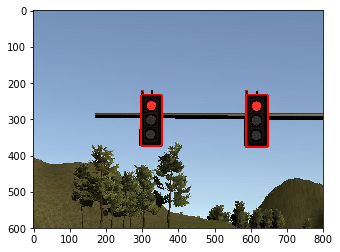

In [31]:
### Check Traffic Sign Annotations ###
# Pick Index
green_idx = 1
yellow_idx = 0
red_idx = 0

# get image name
green_img = green_images_list[green_idx]
yellow_img = yellow_images_list[yellow_idx]
red_img = red_images_list[red_idx]

# plot image
# green folder image
plot_annotation_xml(PATH_TO_GREEN_IMGS + green_img, PATH_TO_XML + green_img.split('.')[0] + '.xml')
# yellow folder image
plot_annotation_xml(PATH_TO_YELLOW_IMGS + yellow_img, PATH_TO_XML + yellow_img.split('.')[0] + '.xml')
# red folder image
plot_annotation_xml(PATH_TO_RED_IMGS + red_img, PATH_TO_XML + red_img.split('.')[0] + '.xml')

In [32]:
### TF Records Conversion ###
import tensorflow as tf
from utils import dataset_util

# convert to TFRecords format
def create_tf_xml(XML_Path):
    
    # read xml info
    xml_info = read_xml(XML_Path)
    
    # get image info
    file_name = get_file_name(xml_info)
    detected_objects = get_detected_objects(xml_info)
    color = get_object_color(detected_objects[0]) # get color to find the correct folder path
    image_path = os.path.join(LABEL_PATH_DICT[color], file_name)
    
    # get image size
    img_size = get_img_size(xml_info)
    height = img_size[1] # Image height
    width = img_size[0] # Image width
    
    # open image
    with tf.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()
    
    # encode
    encoded_image_io = io.BytesIO(encoded_image)
    filename = file_name.encode()
    image_format = 'png'.encode()
    
    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    # loop through each detection
    for box in detected_objects:
        # get detection info
        color = get_object_color(box)
        bounds = get_boxbounds(box)
        
        xmins.append(float(bounds[0]/width))
        ymins.append(float(bounds[1]/height))
        xmaxs.append(float(bounds[2]/width))
        ymaxs.append(float(bounds[3]/height))
        
        classes_text.append(color.encode())
        classes.append(int(LABEL_DICT[color]))
    
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


In [33]:
# fetch all XML files
xml_list = []
for fname in os.listdir(PATH_TO_XML):
    if os.path.splitext(fname)[1] == '.xml':
        xml_list.append(fname)

# TF Records file name
xml2records_filename = 'xml_train.tfrecords'

# Create TFRecords file
writer = tf.python_io.TFRecordWriter(os.path.join(OUTPUT_PATH, xml2records_filename))

for xml_filename in xml_list:
    xml_path = PATH_TO_XML + xml_filename
    tf_example = create_tf_xml(xml_path)
    writer.write(tf_example.SerializeToString())

writer.close()

## BOSCH Traffic Light Dataset

In [40]:
# train with only G,Y,R label
Labels = ["Green", "Yellow", "Red"]
LABEL_DICT = {"Green": 1, "Red": 2, "Yellow": 3}
YAML_PATH = "../../dataset/test.yaml"

# Filter images that are not needed and adjust to correct image path
def process_yaml(input_yaml_path, riib=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    
    images = yaml.load(open(input_yaml_path, 'rb').read())
    print("total images: {}".format(len(images)))
    images_filtered = []
    
    for image in images:
        detections = image['boxes']
        detect_count= 0
        
        for box in detections:
            # count only traffic lights (G,Y,R,off)
            if box['label'] in Labels:
                #if box['occluded'] is False:
                detect_count += 1
            else:
                # just skip if other labels are found
                detect_count -= 5
        
        # save image if detection exist
        if detect_count > 0:
            file_name = os.path.basename(image['path'])
            image['path'] = os.path.abspath(os.path.join('../../dataset/rgb/test/', file_name))
            images_filtered.append(image)
    
    print("filtered images: {}".format(len(images_filtered)))
    return images_filtered

total images: 8334
filtered images: 6724


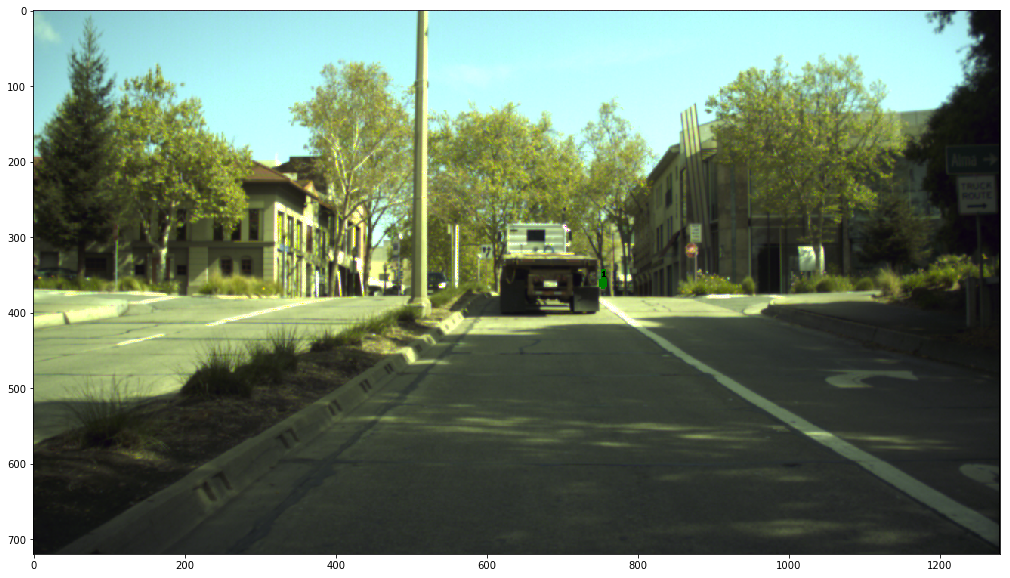

In [41]:
### Test and Plot ###
# Pick an index
test_img_idx = 9

# Import dataset
image_filtered = process_yaml(YAML_PATH)

# Plot
plot_annotation_bosch(image_filtered[test_img_idx])

In [42]:
### Convert to TF Records ###
def create_tf_yaml(yaml_data):
    filename = yaml_data['path'] # Filename of the image. Empty if image is not from file
   
    with tf.gfile.GFile(yaml_data['path'], 'rb') as fid:
        encoded_image = fid.read()
    
    encoded_image_io = io.BytesIO(encoded_image)
    image = Image.open(encoded_image_io)
    width, height = image.size
    
    # encode data
    filename = filename.encode()
    image_format = 'png'.encode()
    
    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
                # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
                # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    for box in yaml_data['boxes']:
        xmins.append(float(box['x_min'] / width))
        xmaxs.append(float(box['x_max'] / width))
        ymins.append(float(box['y_min'] / height))
        ymaxs.append(float(box['y_max'] / height))
        classes_text.append(box['label'].encode())
        classes.append(int(LABEL_DICT[box['label']]))
        
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    return tf_example


In [43]:
import io

# get all XML files
output_path = os.path.dirname("../../output_data/")
yaml_filename = 'yaml_train.tfrecords'

# create dir if not found
try:
    os.stat(output_path)
except:
    os.mkdir(output_path)

# open TF Record file
writer = tf.python_io.TFRecordWriter(os.path.join(output_path, yaml_filename))

for image_yaml in image_filtered:
    tf_example = create_tf_yaml(image_yaml)
    writer.write(tf_example.SerializeToString())

writer.close()